In [40]:
from collections import Counter
import itertools
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import spacy

# Download the following required data resources if not already downloaded and needed

# NLTK stopwords
nltk.download('stopwords', quiet=True)

# If using WordNetLemmatizer with POS tag support, you'll need the following NLTK data sets
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# If using the spaCy lemmatizer, you'll need the following spaCy data set downloaded
#  for spaCy english words:
# !python -m spacy download en_core_web_sm


True

In [2]:
bbcnews_train = pd.read_csv('data/BBC News Train.csv')
bbcnews_test = pd.read_csv('data/BBC News Test.csv')
bbcnews_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
bbcnews_test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [4]:
bbcnews_train.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [5]:
bbcnews_test.isnull().sum()

ArticleId    0
Text         0
dtype: int64

In [6]:
bbcnews_train.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

In [7]:
# Find duplicate rows in the training dataset where 'Text' is not unique
train_duplicates = bbcnews_train[bbcnews_train.duplicated(subset=['Text'], keep=False)]
print(f"Number of duplicate rows: {len(train_duplicates)}")
display(train_duplicates.sort_values(by='Text'))


Number of duplicate rows: 100


,ArticleId,Text,Category
494,1326,ask jeeves joins web log market ask jeeves has...,tech
228,1098,ask jeeves joins web log market ask jeeves has...,tech
1430,1042,aviator creator in oscars snub the man who s...,entertainment
695,374,aviator creator in oscars snub the man who s...,entertainment
443,1847,blind student hears in colour a blind studen...,tech
...,...,...,...
1047,789,virus poses as christmas e-mail security firms...,tech
1409,957,web radio takes spanish rap global spin the ra...,tech
616,110,web radio takes spanish rap global spin the ra...,tech
63,2017,what high-definition will do to dvds first it ...,tech


In [8]:
# Group duplicates by Text and check if all rows in each group have the same Category
print("Analysis of duplicate texts in training dataset:")
for text, group in train_duplicates.groupby('Text'):
    categories = group['Category'].unique()
    if len(categories) == 1:
        print(f"Text (truncated): '{text[:50]}...' has {len(group)} duplicates, all with category: {categories[0]}")
    else:
        print(f"Text (truncated): '{text[:50]}...' has {len(group)} duplicates with different categories: {categories}")

# Count how many duplicate texts have consistent vs inconsistent categories
same_category = 0
different_category = 0

for text, group in train_duplicates.groupby('Text'):
    if len(group['Category'].unique()) == 1:
        same_category += 1
    else:
        different_category += 1

print(f"\nSummary:")
print(f"- Duplicate texts with the same category: {same_category}")
print(f"- Duplicate texts with different categories: {different_category}")

Analysis of duplicate texts in training dataset:
Text (truncated): 'ask jeeves joins web log market ask jeeves has bou...' has 2 duplicates, all with category: tech
Text (truncated): 'aviator  creator  in oscars snub the man who said ...' has 2 duplicates, all with category: entertainment
Text (truncated): 'blind student  hears in colour  a blind student ha...' has 2 duplicates, all with category: tech
Text (truncated): 'bortolami predicts dour contest italy skipper marc...' has 2 duplicates, all with category: sport
Text (truncated): 'britons fed up with net service a survey conducted...' has 2 duplicates, all with category: tech
Text (truncated): 'brown outlines third term vision gordon brown has ...' has 2 duplicates, all with category: politics
Text (truncated): 'california sets fines for spyware the makers of co...' has 2 duplicates, all with category: tech
Text (truncated): 'camera phones are  must-haves  four times more mob...' has 2 duplicates, all with category: tech
Text (tru

In [9]:
# list categories and count for each
bbcnews_train.groupby('Category').count()

,ArticleId,Text
Category,,
business,336,336
entertainment,273,273
politics,274,274
sport,346,346
tech,261,261


In [10]:
# remove duplicates
bbcnews_train = bbcnews_train.drop_duplicates(subset = ['Text'], keep = 'first')
remaining_dups = bbcnews_train[bbcnews_train.duplicated(subset=['Text'], keep=False)]
print(f"Remaining duplicates in the training dataset: {len(remaining_dups)}")

Remaining duplicates in the training dataset: 0


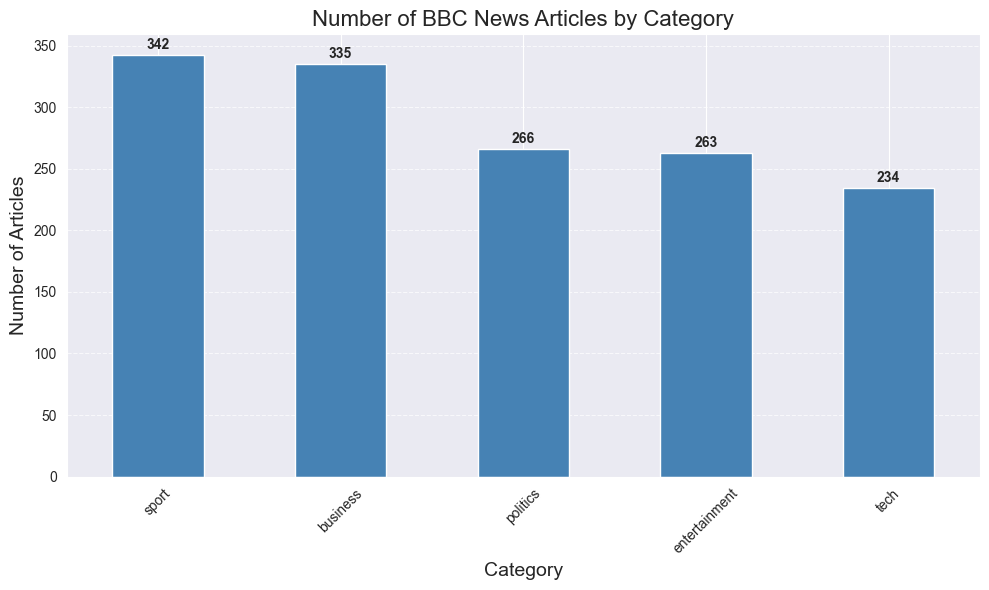

In [11]:
# Plot the number of articles in each category

# Get counts by categorry
category_counts = bbcnews_train['Category'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = category_counts.plot(kind='bar', color='steelblue')
plt.title('Number of BBC News Articles by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the counts on top of each bar
for i, count in enumerate(category_counts):
    plt.text(i, count + 5, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


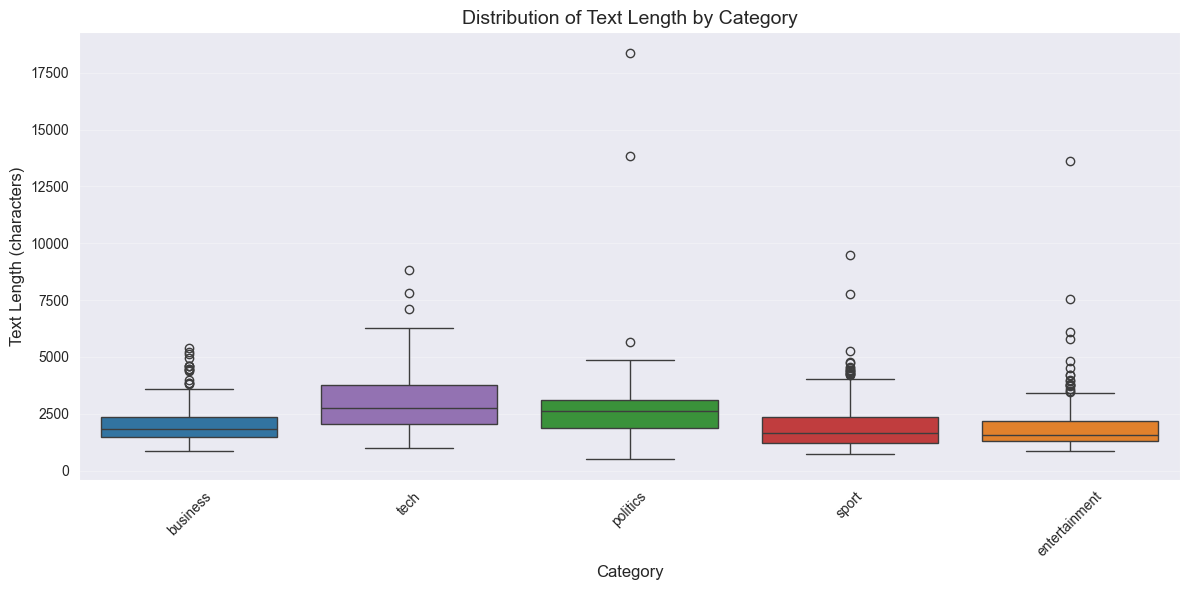

In [12]:
# Distribution of article length by category

# Calculate the length for each article
bbcnews_train['text_length'] = bbcnews_train['Text'].apply(len)

# Create a box plot to compare text length by category
category_colors = {
    'business': '#1f77b4',      # blue
    'entertainment': '#ff7f0e', # orange
    'politics': '#2ca02c',      # green
    'sport': '#d62728',         # red
    'tech': '#9467bd'           # purple
}
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='text_length', data=bbcnews_train, palette=category_colors, hue='Category')
plt.title('Distribution of Text Length by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

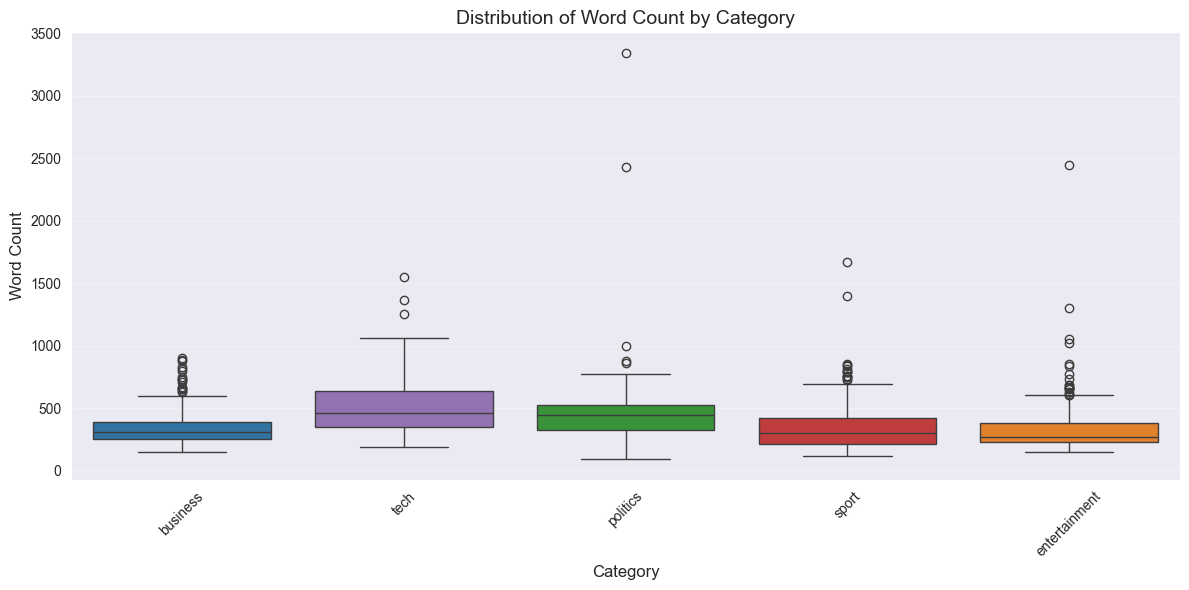

In [13]:
# Plot the distribution of word counts

# Calculate the word count for each article
bbcnews_train['word_count'] = bbcnews_train['Text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='word_count', data=bbcnews_train, palette=category_colors, hue='Category')
plt.title('Distribution of Word Count by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


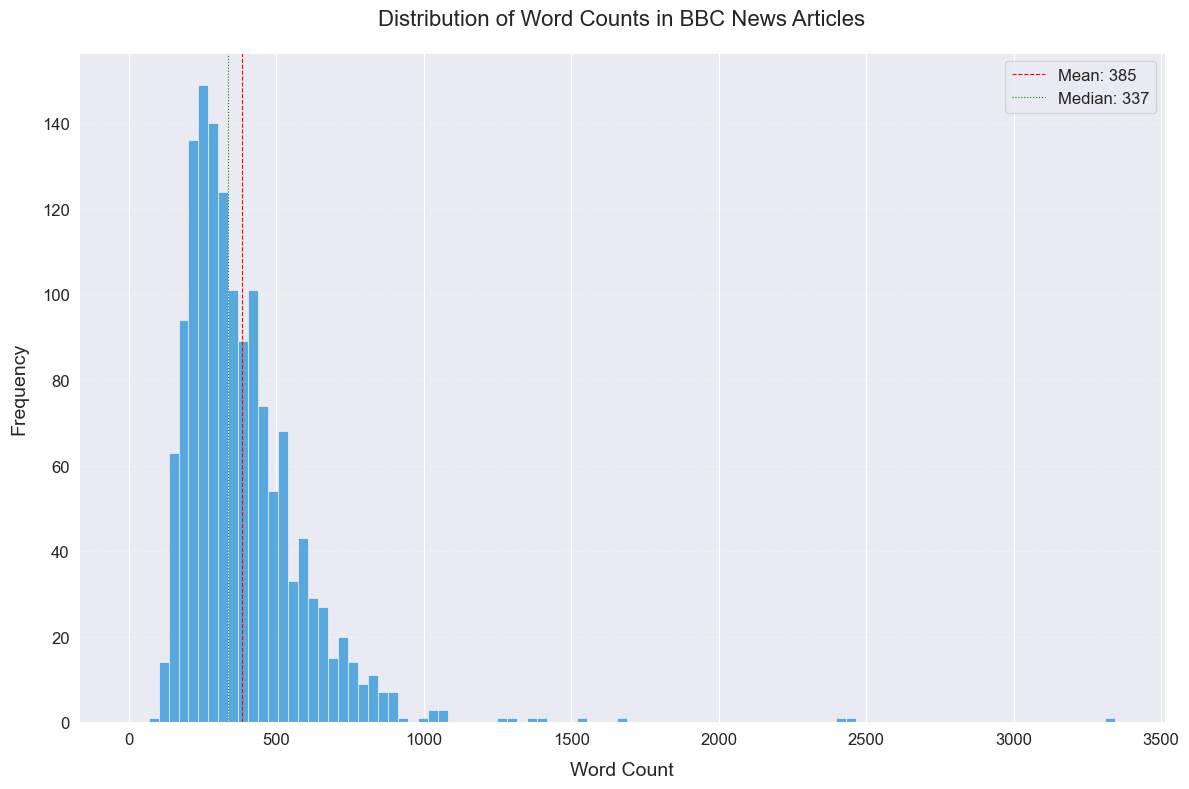

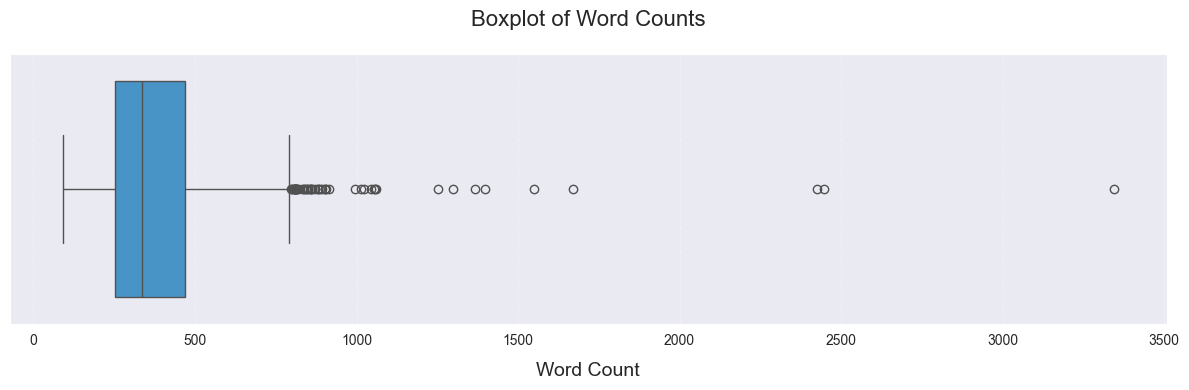

In [14]:
# The the distribution of the word count for all articles
plt.figure(figsize=(12, 8))

# Create the histogram of word counts
bins = np.linspace(0, bbcnews_train['word_count'].max(), 100)
n, bins, patches = plt.hist(bbcnews_train['word_count'], bins=bins,
                            color='#3498db', alpha=0.8, edgecolor='white', linewidth=0.5)

# Calculate statistics
mean_val = bbcnews_train['word_count'].mean()
median_val = bbcnews_train['word_count'].median()
mode_val = bbcnews_train['word_count'].mode()[0]
std_val = bbcnews_train['word_count'].std()

# Add vertical lines for mean and median (with thinner lines)
plt.axvline(x=mean_val, color='red', linestyle='--', linewidth=0.8, label=f'Mean: {mean_val:.0f}')
plt.axvline(x=median_val, color='green', linestyle=':', linewidth=0.8, label=f'Median: {median_val:.0f}')

plt.title('Distribution of Word Counts in BBC News Articles', fontsize=16, pad=20)
plt.xlabel('Word Count', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Associated boxplot for the word count distribution
plt.figure(figsize=(12, 4))
sns.boxplot(x=bbcnews_train['word_count'], color='#3498db')
plt.title('Boxplot of Word Counts', fontsize=16, pad=20)
plt.xlabel('Word Count', fontsize=14, labelpad=10)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show();


In [23]:
# Create a custom transformer to perform text cleanup (usable in pipeline later)
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, min_word_length = 2, max_word_count = 0, method = 'simple', additional_words = None, stop_words = None):
        self.min_word_length = min_word_length
        self.max_word_count = max_word_count
        self.method = method
        self.additional_words = additional_words
        self.stop_words = stop_words if stop_words else set(stopwords.words('english'))
        self.remove_words = self.stop_words if not self.additional_words else self.stop_words.union(self.additional_words)

    # empty fit function to support use in pipeline
    def fit(self, X, y = None):
        return self

    # transform function for _cleanup_text to support use in pipeline
    def transform(self, X):
        if hasattr(X, 'apply'):
            return X.apply(self._cleanup_text)
        else:
            return [self._cleanup_text(text) for text in X]

    # Function to perform the text cleanup and stem/lemmatize as specified
    def _cleanup_text(self, text):
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = re.sub(r'[^\w\s]', ' ', text)

        # Remove numbers
        text = re.sub(r'\d+', ' ', text)

        # Process words (lemmatize, removing stopwords and additional words supplied, short words, and extra spaces)
        match self.method:
            case 'spaCy' | 'spacy':
                words = self._spacy_lemma(text)
            case 'wordnet':
                words = self._wordnet_lemma(text)
            case 'snowball':
                words = self._snowball_stemmer(text)
            case _:  # default to 'simple'
                words = self._simple_tokens(text)

        # Limit to max word count if specified
        if self.max_word_count > 0:
            words = words[:self.max_word_count]

        return ' '.join(words)

    # Simple word tokens, removing words in the remove_words list and short words
    def _simple_tokens(self, text):
        tokens = text.split()
        return [token for token in tokens if token not in self.remove_words and len(token) > self.min_word_length]

    # spaCy lemmatizer
    def _spacy_lemma(self, text):
        # spaCy english words - Needed if using the spaCy lemmatizer option and not already downloaded - see Imports

        nlp = spacy.load("en_core_web_sm")  # For spaCy lemmatizing option
        tokens = nlp(text)  # use spaCy to generate tokens

        # Process words (lemmatize, removing stopwords and additional words supplied, short words, and extra spaces)
        return [token.lemma_ for token in tokens if token.text not in self.remove_words
                 and token.lemma_ not in self.remove_words and len(token) > self.min_word_length and not token.is_space]

    # WordNetLemmatizer
    def _get_wordnet_pos(self, nltk_tag):
        # Map for most common matches on the first letter of the tag
        pos_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADV}

        # Map NLTK POS tags to WordNet POS tags
        if nltk_tag[0] in pos_map:
            return pos_map[nltk_tag[0]]
        elif nltk_tag in ('MD', 'TO'):  # Modal, infinitive marker
            return wordnet.VERB
        else:
             return wordnet.NOUN  # Default to Noun for other cases

    def _wordnet_lemma(self, text):
        # NLTK data needed for wordnet and pos_tag - see Imports
        lemmatizer = WordNetLemmatizer()
        tokens = self._simple_tokens(text)

        # Get POS (part of speech) tags
        tagged_tokens = pos_tag(tokens)

        # Lemmatize with POS tag
        lemmatized_words = []
        for word, tag in tagged_tokens:
            if word not in self.remove_words and len(word) > self.min_word_length:
                # Get the WordNet POS tag
                wordnet_pos = self._get_wordnet_pos(tag)

                # Lemmatize with the appropriate POS tag
                lemma = lemmatizer.lemmatize(word, wordnet_pos)
                lemmatized_words.append(lemma)

        return lemmatized_words

    # SnowballStemmer
    def _snowball_stemmer(self, text):
        stemmer = SnowballStemmer("english")
        tokens = self._simple_tokens(text)

        # apply stemming
        words = [stemmer.stem(word) for word in tokens]

        return words


In [16]:
# Cleanup the article Text - default simple method
text_cleaner = TextCleaner(method = 'simple')
bbcnews_train['Text_cleaned'] = text_cleaner.transform(bbcnews_train['Text'])
print("Original Text: ", bbcnews_train['Text'][0], "\n\n")
print("Cleaned Text: ", bbcnews_train['Text_cleaned'][0])

Original Text:  worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by w

In [25]:
# Find most common words in each category and across categories

# Helper function to get the top N words from a category
def get_top_n_words(category, top_n=30):
    # Get the articles for the specified category
    category_data = bbcnews_train[bbcnews_train['Category'] == category]

    # Combine all cleaned text for this category
    all_words = ' '.join(category_data['Text_cleaned']).split()

    # Count word frequencies and get the top N
    top_words = Counter(all_words).most_common(top_n)

    return top_words


def get_top_m_common_words(top_m=30, top_n=100, sort_by='average'):
    # Get the top_n words for each category
    categories = bbcnews_train['Category'].unique()
    category_words = {}
    for category in categories:
        category_words[category] = dict(get_top_n_words(category, top_n))

    # Find common words in all categories
    common_words = set(category_words[categories[0]].keys())
    for category in categories[1:]:
        common_words = common_words.intersection(set(category_words[category].keys()))

    print(f"The number of common words in all categories is {len(common_words)}")

    # Get the counts for each word
    # Create a DataFrame with counts for each word in each category
    data = []
    for word in common_words:
        row = {'word': word}
        counts = []
        for cat in categories:
            count = category_words[cat][word]
            row[cat] = count
            counts.append(count)

        # Calculate statistics
        row['total_count'] = sum(counts)
        row['avg_count'] = np.mean(counts)
        row['min_count'] = min(counts)
        row['max_count'] = max(counts)
        row['std_dev'] = np.std(counts)
        row['cv'] = row['std_dev'] / row['avg_count'] if row['avg_count'] > 0 else 0  # Coefficient of variation

        data.append(row)
    result_df = pd.DataFrame(data)

    # Sort based on the specified method
    match sort_by:
        case 'total':
            result_df = result_df.sort_values('total_count', ascending=False)
        case 'min_count':
            result_df = result_df.sort_values('min_count', ascending=False)
        case 'consistency':
            result_df = result_df.sort_values('cv', ascending=True)  # Lower CV means more consistent across categories
        case _:  # default to 'average'
            result_df = result_df.sort_values('avg_count', ascending=False)

    result_df = result_df.reset_index(drop=True)

    # Return top m common words
    return result_df.head(top_m)


common_category_words = get_top_m_common_words(top_n=30)
display(common_category_words)

The number of common words in all categories is 7


,word,business,tech,politics,sport,entertainment,total_count,avg_count,min_count,max_count,std_dev,cv
0,say,1276,1168,1841,746,676,5707,1141.4,676,1841,419.810243,0.367803
1,year,614,321,291,447,434,2107,421.4,291,614,114.011578,0.270554
2,would,309,290,685,233,135,1652,330.4,135,685,187.349513,0.567038
3,make,238,357,297,297,225,1414,282.8,225,357,47.448498,0.167781
4,also,279,310,298,212,267,1366,273.2,212,310,34.019994,0.124524
5,new,275,334,271,202,231,1313,262.6,202,334,44.706152,0.170244
6,one,189,325,187,264,267,1232,246.4,187,325,52.412212,0.212712


In [26]:
# Remove the common words from the word list
remove_common = common_category_words['word'].tolist()

# Cleanup the article Text
text_cleaner = TextCleaner(additional_words=remove_common)
bbcnews_train['Text_cleaned'] = text_cleaner.transform(bbcnews_train['Text'])
print("Original Text: ", bbcnews_train['Text'][0], "\n\n")
print("Cleaned Text: ", bbcnews_train['Text_cleaned'][0])

Original Text:  worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by w

In [27]:
# Create and display treemaps for the top words in each category
# Helper function to create the treemaps for each category
def create_category_treemap(category, top_n=30):

    # Create dataframe for treemap
    treemap_data = pd.DataFrame(get_top_n_words(category, top_n), columns=['word', 'count'])

    # Custom color schemes for each category
    color_schemes = {
        'business': 'Blues',
        'entertainment': 'Teal',
        'politics': 'Greens',
        'sport': 'Reds',
        'tech': 'Purples'
    }

    # Create treemap
    fig = px.treemap(
        treemap_data,
        path=['word'],
        values='count',
        title=f'Most Common Words in {category.capitalize()} Articles',
        color='count',
        color_continuous_scale=color_schemes.get(category, 'Viridis'),
        height=600
    )

    fig.update_layout(
        margin=dict(t=50, l=25, r=25, b=25),
        font=dict(size=14)
    )

    fig.update_traces(
        textinfo='label+value',
        hovertemplate='<b>%{label}</b><br>Count: %{value}<extra></extra>'
    )

    return fig


for category in bbcnews_train['Category'].unique():
    fig = create_category_treemap(category)
    fig.show()


In [30]:
# Build and Evaluate the model

# Helper function to match categories with NMF results
def label_permute_compare(ytdf,yp,labels):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
    print(f"using labels list: {labels}")
    perms = [list(perm) for perm in itertools.permutations(labels, len(labels))]  # create a list of permutations for the labels

    # convert target labels df to array
    ytlist = ytdf.iloc[:, 0].to_numpy()

    # iterate through the permutations and calculate accuracy
    label_acc = []
    for perm in perms:
        # create an array of labels for the prediction, using the permutation list and the cluster number as the index
        yp_labels = np.array(perm)[yp]
        # get the accurcy score using the ground truth labels against this iteration of prediction labels
        label_acc.append((accuracy_score(ytlist, yp_labels), perm))  #

    # get the results with the highest accuracy
    best_accuracy = max(label_acc, key=lambda x: x[0])
    print(f"best accuracy: {best_accuracy[0]}")
    print(f"best class label order (0, 1, 2, 3, 4) = {best_accuracy[1]}")

    # map the best label order back to the original labels list for the permuted label order
    indices = [labels.index(label) for label in best_accuracy[1]]
    print(f"index order from starting labels lists: {indices}\n")

    return tuple(indices), best_accuracy[0]


In [28]:
# Number of categories
n_categories = len(bbcnews_train['Category'].unique())

# Create a pipeline to clean, tranform, and vectorize the text and perform NMF
nmf_pipeline = Pipeline([
    ('text_cleaner', TextCleaner(method='simple', additional_words=remove_common)),
    ('tfidf', TfidfVectorizer(
        min_df=5,
        max_df=0.95,
        analyzer='word',
        ngram_range=(1, 2),
        sublinear_tf=True,
        token_pattern=r'\b\w+\b'
    )),
    ('nmf', NMF(
        n_components=n_categories,
        random_state=42,
        max_iter=200,
        solver='mu',
        beta_loss='kullback-leibler',
        alpha_H=0.0,
        l1_ratio=0.5,
        init='nndsvda'
    ))
])

Clean the article text (four options tested)

* Simple method, removing common words

    * bbcnews_train['Text_cleaned'] = bbcnews_train['Text'].apply(lambda text: cleanup_text(text, additional_words=remove_common))

    * accuracy = 0.9369, time = 3s

* spaCy lemmatizer

    * bbcnews_train['Text_cleaned'] = bbcnews_train['Text'].apply(lambda text: cleanup_text(text, additional_words=remove_common, method = 'spaCy'))

    * accuracy = 0.9368, time = 10m50s

* Wordnet lemmatizer with POS tag

    * bbcnews_train['Text_cleaned'] = bbcnews_train['Text'].apply(lambda text: cleanup_text(text, additional_words=remove_common, method = 'wordnet'))

    * accuracy = 0.9563, time = 19s

* Snowball stemmer

    * bbcnews_train['Text_cleaned'] = bbcnews_train['Text'].apply(lambda text: cleanup_text(text, additional_words=remove_common, method = 'snowball'))

    * accuracy = 0.9625, time = 5s



Topics extracted from training data:
Topic #0: people technology said users use mobile software internet online phone
Topic #1: game win england cup team said match first season players
Topic #2: government labour election blair said party minister prime prime minister people
Topic #3: film best awards star award show actor music films band
Topic #4: said market company firm growth shares economy bank economic financial


using labels list: ['business', 'entertainment', 'politics', 'sport', 'tech']
best accuracy: 0.9652777777777778
best class label order (0, 1, 2, 3, 4) = ['tech', 'sport', 'politics', 'entertainment', 'business']
index order from starting labels lists: [4, 3, 2, 1, 0]

Train Accuracy: 0.9653


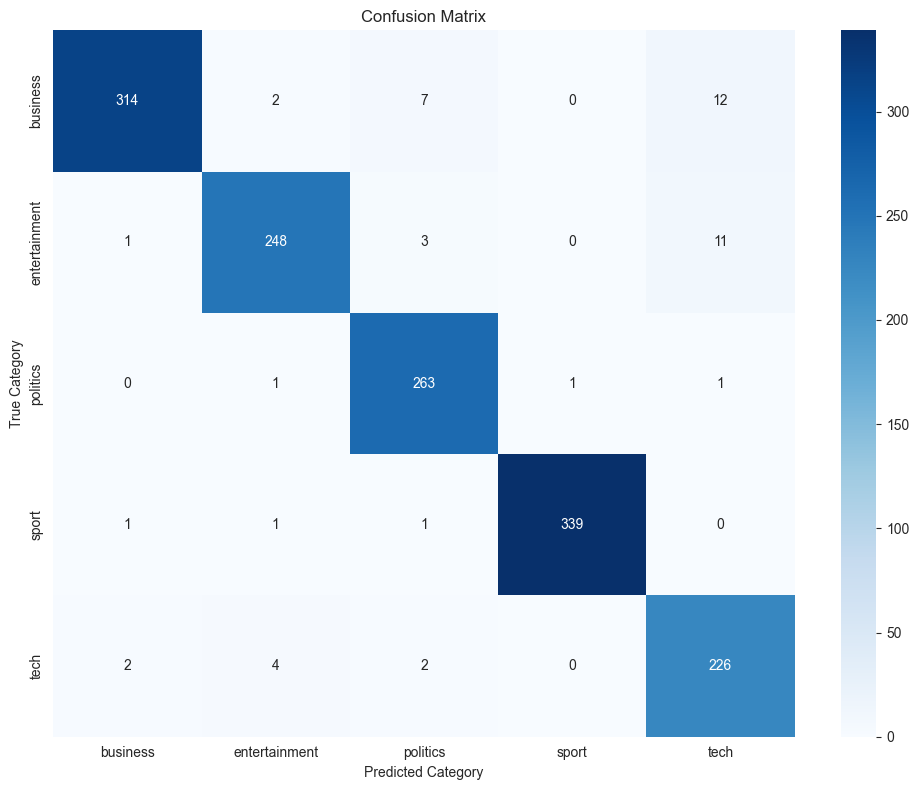

In [31]:
# Clean, transform, vectorize, and fit the article text
y_hat_train = nmf_pipeline.fit_transform(bbcnews_train['Text'])

# Extract and display topics
print("\nTopics extracted from training data:")
feature_names = nmf_pipeline.named_steps['tfidf'].get_feature_names_out()
for topic_idx, topic in enumerate(nmf_pipeline.named_steps['nmf'].components_):
    top_words_idx = topic.argsort()[:-11:-1]  # Get indices of top 10 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic #{topic_idx}: {' '.join(top_words)}")
print("\n")

# Assign the dominant topic as the prediction
y_pred = y_hat_train.argmax(axis=1)

# Get the true categories
y_true = pd.DataFrame(bbcnews_train['Category'], columns=['Category'])

# Get the category permutation mapping that achieves the highest accuracy for the clusters
categories = np.unique(y_true).tolist()
topic_to_category_idx, accuracy = label_permute_compare(y_true, y_pred, categories)

# Map the predicted topics to category names from the permutation results
category_mapping = {i: categories[idx] for i, idx in enumerate(topic_to_category_idx)}

# Convert the topic numbers to category names
predicted_categories = [category_mapping[topic] for topic in y_pred]

# Add predictions to the training dataframe
bbcnews_train['Predicted_Category'] = predicted_categories

# Display the training accuracy
accuracy = accuracy_score(bbcnews_train['Category'], bbcnews_train['Predicted_Category'])
print(f"Train Accuracy: {accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(bbcnews_train['Category'], bbcnews_train['Predicted_Category'])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.ylabel('True Category')
plt.xlabel('Predicted Category')
plt.tight_layout()
plt.show()


In [32]:
# Generate predictions for Test data set
nmf_test = bbcnews_test.copy()

# Predict the target category on the Test data set using the train pipeline
y_hat_test = nmf_pipeline.transform(nmf_test['Text'])
y_pred = y_hat_test.argmax(axis=1)
predicted_categories = [category_mapping[topic] for topic in y_pred]
nmf_test['Category'] = predicted_categories

# drop unneeded columns
nmf_test = nmf_test.drop(['Text'], axis=1)
nmf_test.head(10)


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


In [33]:
# save submission
try:
    nmf_test.to_csv('submission.csv', index=False)
except:
    ...


### Model Comparison

In [37]:
# Split the current Train data set into a train and test sets to evaluate supervised model(s)
X_train, X_test, y_train, y_test = train_test_split(
    bbcnews_train.Text,
    bbcnews_train.Category,
    test_size=0.2,
    random_state=42,
    stratify=bbcnews_train.Category  # Maintain class distribution
)

In [54]:
# Support Vector Machine model
svm_pipeline = Pipeline([
    ('cleaner', TextCleaner(method='wordnet', additional_words=remove_common)),
    ('tfidf', TfidfVectorizer(
        min_df=5,
        max_df=0.95,
        analyzer='word',
        ngram_range=(1, 2),
        sublinear_tf=True,
        token_pattern=r'\b\w+\b'
    )),
    ('classifier', LinearSVC(C=1.0, dual=False))
])

# Train the model
svm_pipeline.fit(X_train, y_train)

# Predict on test data
y_pred_svm = svm_pipeline.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy on test set: {accuracy_svm:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

Accuracy on test set: 0.9688

Classification Report:
               precision    recall  f1-score   support

     business       0.97      0.99      0.98        67
entertainment       0.96      0.94      0.95        53
     politics       0.98      0.96      0.97        53
        sport       0.97      1.00      0.99        68
         tech       0.96      0.94      0.95        47

     accuracy                           0.97       288
    macro avg       0.97      0.97      0.97       288
 weighted avg       0.97      0.97      0.97       288

